# Analyse des Sentiments sur les réseaux sociaux : interview de Poutine et Carlson du 09/02/2024

### Objectifs : 
- Traitement du langage naturel (NLP) : utilisez des techniques de NLP avancées, telles que l'analyse des sentiments, la modélisation de sujets et la détection des émotions, pour découvrir des modèles et des sentiments sous-jacents. Outils : BERT et GPT.
- Apprentissage automatique : utilisez des algorithmes d'apprentissage automatique pour classer les commentaires, prédire les scores de sentiment et analyser les mesures d'engagement.
- Visualisation des données : créez des visualisations convaincantes pour représenter les distributions de sentiments.

### Description des colonnes :
- Commentaire : Le contenu textuel du commentaire de l'utilisateur.
- Auteur anonymisé : une représentation hachée SHA-256 du nom d'utilisateur de l'auteur du commentaire pour garantir la confidentialité.
- Publié à : Horodatage indiquant la date à laquelle le commentaire a été publié.
- J'aime : Le nombre de likes reçus par un commentaire.
- Nombre de réponses : Le nombre de réponses au commentaire.


Nous analysons ces données de manière objective pour mieux comprendre le sentiment public sur les grandes questions mondiales, mettant en valeur la capacité de la science des données à éclairer les complexités du discours humain.

### Importation des bibliothèques

In [7]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import warnings  # Utilisé pour supprimer les avertissements gênants

### Chargement et description des données

In [9]:
df = pd.read_csv('putin_tucker.csv')
df.describe(include='all').transpose()

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Comment,100000,401,❤,1994,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Anonymized Author,100000,100000,533fb31af87a0ff551c4dc7a73634ccf7e9005f8eb4673...,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Published At,100000,403,2024-02-17T22:32:34Z,997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Likes,100000.0,NaN,NaN,NaN,52.22723,310.010713,0.0,0.0,2.0,11.0,79514.0
Reply Count,100000.0,NaN,NaN,NaN,2.38692,7.695083,0.0,0.0,0.0,1.0,750.0


### Distribution des commentaires uniques

Number of comments with the same text,Number of unique comment contents that have this number of repetitions
1,298
2,1
5,1
128,1
324,1
545,1
992,1
997,96
1994,1


Text(0, 0.5, 'Repetition count')

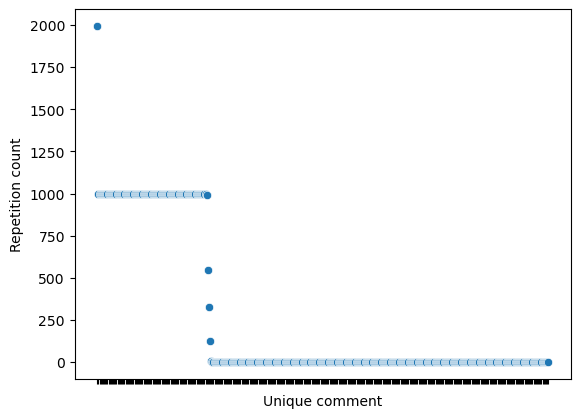

In [11]:
# Calculer le nombre de répétitions de chaque commentaire
unique_comment_dist = df.groupby('Comment')['Anonymized Author'].count().sort_values(ascending=False)

# Obtenir les valeurs uniques et leurs fréquences
uc_values, uc_counts = np.unique(unique_comment_dist.values, return_counts=True)

# Créer un DataFrame pour visualiser les résultats
uc_df = pd.DataFrame({
    'Number of comments with the same text': uc_values,
    'Number of unique comment contents that have this number of repetitions': uc_counts
})

# Afficher le DataFrame sous forme de tableau HTML
from IPython.display import display, HTML
display(HTML(uc_df.to_html(index=False)))

# Visualisation des répétitions des commentaires uniques
plot = sns.scatterplot(unique_comment_dist)
plot.set_xticklabels([])
plot.set_xlabel('Unique comment')
plot.set_ylabel('Repetition count')

### Création de l'indicateur 'IsBotComment'

In [13]:
# Basé sur le graphique en dispersion ci-dessus, créons un indicateur 'IsBotComment'
df['DEV__IsBotComment'] = df['Comment'].isin(unique_comment_dist[unique_comment_dist > 1].index)

# Compter les occurrences de l'indicateur 'IsBotComment'
df['DEV__IsBotComment'].value_counts()

DEV__IsBotComment
True     99702
False      298
Name: count, dtype: int64

### Histogrammes des "Likes" pour les commentaires réels et les commentaires de bots

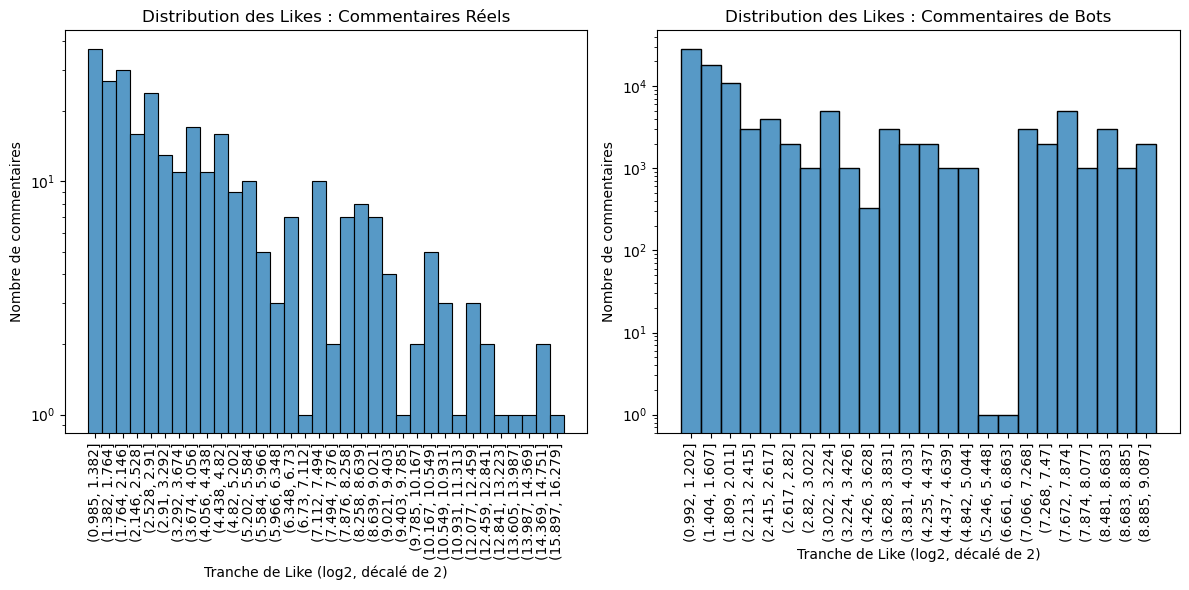

In [15]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Histogramme des commentaires réels
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Distribution des "Likes" pour les commentaires réels (décalés de 2 pour éviter le log de zéro)
    bucketed_like_counts_real = pd.cut(np.log2(df[~df['DEV__IsBotComment']]['Likes'].sort_values() + 2), bins=40).astype(str)
    sns.histplot(bucketed_like_counts_real, ax=axs[0])
    axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation=90)
    axs[0].set_yscale('log')
    axs[0].set_xlabel('Tranche de Like (log2, décalé de 2)')
    axs[0].set_ylabel('Nombre de commentaires')
    axs[0].set_title('Distribution des Likes : Commentaires Réels')
    
# Histogramme des commentaires de bots
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    # Distribution des "Likes" pour les commentaires de bots (décalés de 2 pour éviter le log de zéro)
    bucketed_like_counts_bot = pd.cut(np.log2(df[df['DEV__IsBotComment']]['Likes'].sort_values() + 2), bins=40).astype(str)
    sns.histplot(bucketed_like_counts_bot, ax=axs[1])
    axs[1].set_xticklabels(axs[1].get_xticklabels(), rotation=90)
    axs[1].set_yscale('log')
    axs[1].set_xlabel('Tranche de Like (log2, décalé de 2)')
    axs[1].set_ylabel('Nombre de commentaires')
    axs[1].set_title('Distribution des Likes : Commentaires de Bots')

# Ajuster la mise en page et afficher les graphiques
plt.tight_layout()
plt.show()

### Description des "Likes" sur les commentaires réels

In [17]:
df[~df['DEV__IsBotComment']]['Likes'].describe(percentiles=[.25, .75, .9, .95, .99]).rename('Likes on real comments')

count      298.000000
mean       766.218121
std       5224.981883
min          0.000000
25%          2.000000
50%          8.000000
75%         52.500000
90%        477.200000
95%       1414.650000
99%      19898.090000
max      79514.000000
Name: Likes on real comments, dtype: float64

### Description des "Likes" sur les commentaires de bots

In [19]:
df[df['DEV__IsBotComment']]['Likes'].describe(percentiles=[.25, .75, .9, .95, .99]).rename('Likes on bot comments')

count    99702.000000
mean        50.093178
std        116.362272
min          0.000000
25%          0.000000
50%          2.000000
75%         11.000000
90%        214.000000
95%        389.000000
99%        471.000000
max        542.000000
Name: Likes on bot comments, dtype: float64

### Préparation des données pour les commentaires réels et les commentaires de bots

Pour les commentaires réels :

In [21]:
df_gen = df[~df['DEV__IsBotComment']].drop(['DEV__IsBotComment', 'Published At', 'Anonymized Author'], axis=1)

Pour les commentaires de bots :

In [25]:
df_bot = df[df['DEV__IsBotComment']].drop(['DEV__IsBotComment', 'Published At', 'Anonymized Author'], axis=1)

### Analyse des commentaires de bots

Pour un examen manuel ultérieur :

In [27]:
df_bot_unique = df_bot.groupby('Comment').agg(['mean', 'count'])

Pour l'analyse sémantique :

In [29]:
df_bot_unique_df = pd.DataFrame({
    'Likes': df_bot_unique['Likes']['mean'],
    'Reply Count': df_bot_unique['Reply Count']['mean']
}).reset_index()

### Téléchargement des ressources nltk

In [31]:
import nltk
nltk.download()

showing info https://raw.githubusercontent.com/nltk/nltk_data/gh-pages/index.xml


True

### Préparation des ressources NLTK et initialisation des outils

In [32]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment import SentimentIntensityAnalyzer

# Téléchargement des données NLTK nécessaires
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('vader_lexicon')

# Correction de bug Kaggle. Échoue autrement.
import subprocess
wordnet_path = '/usr/share/nltk_data/corpora/wordnet.zip'
command = f"unzip {wordnet_path} -d /usr/share/nltk_data/corpora/"
subprocess.run(command.split())
nltk.data.path.append('/usr/share/nltk_data')

# Vérification du téléchargement de WordNet
from nltk.corpus import wordnet as wn
print(wn.ensure_loaded())

# Initialisation du lemmatizer
lemmatizer = WordNetLemmatizer()

# Initialisation de l'analyseur de sentiment
sia = SentimentIntensityAnalyzer()

# Définition de la fonction de prétraitement du texte
def preprocess_text(text):
    # Tokenisation du texte
    tokens = word_tokenize(text.lower())
    
    # Suppression des mots vides
    filtered_tokens = [token for token in tokens if token not in stopwords.words('english')]
    
    # Lemmatization des tokens
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in filtered_tokens]
    
    # Reconstitution des tokens en chaîne de caractères
    processed_text = ' '.join(lemmatized_tokens)
    
    return processed_text

[nltk_data] Downloading package punkt to /Users/user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/user/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/user/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
unzip:  cannot find or open /usr/share/nltk_data/corpora/wordnet.zip, /usr/share/nltk_data/corpora/wordnet.zip.zip or /usr/share/nltk_data/corpora/wordnet.zip.ZIP.


None


### Fonction d'analyse des commentaires dans un DataFrame

In [35]:
def analyze_comment_df(df):
    df = df.copy()
    df['DEV__PreprocessedComment'] = df['Comment'].apply(preprocess_text)
    df['DEV__Sentiment'] = df['DEV__PreprocessedComment'].apply(lambda text: sia.polarity_scores(text))
    for arg in ['neg', 'neu', 'pos', 'compound']:
        df['DEV__Sentiment__' + arg] = df['DEV__Sentiment'].apply(lambda x: x[arg])
    return df.drop('DEV__Sentiment', axis=1)

### Analyse descriptive du DataFrame des commentaires réels après traitement

In [37]:
df_gen_res = analyze_comment_df(df_gen)
df_gen_res.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Likes,298.0,766.218121,5224.981883,0.0000,2.00000,8.0000,52.50000,79514.0000
Reply Count,298.0,18.077181,87.847956,0.0000,0.00000,1.0000,3.00000,750.0000
DEV__Sentiment__neg,298.0,0.074651,0.133683,0.0000,0.00000,0.0000,0.12100,0.7920
DEV__Sentiment__neu,298.0,0.643470,0.254890,0.0000,0.46225,0.6320,0.83750,1.0000
DEV__Sentiment__pos,298.0,0.281859,0.255651,0.0000,0.00000,0.2520,0.44875,1.0000
DEV__Sentiment__compound,298.0,0.293348,0.450565,-0.9428,0.00000,0.3612,0.65970,0.9903


### Analyse descriptive du DataFrame des commentaires de bots après traitement

In [39]:
df_bot_res = analyze_comment_df(df_bot_unique_df)
df_bot_res.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Likes,103.0,49.451456,115.427520,0.0000,0.000,2.0000,11.0000,542.0000
Reply Count,103.0,2.276757,5.924668,0.0000,0.000,0.0000,1.0000,35.0000
DEV__Sentiment__neg,103.0,0.066612,0.115845,0.0000,0.000,0.0000,0.1185,0.5650
DEV__Sentiment__neu,103.0,0.691417,0.272033,0.0000,0.507,0.6870,1.0000,1.0000
DEV__Sentiment__pos,103.0,0.232272,0.239874,0.0000,0.000,0.1870,0.3840,0.8700
DEV__Sentiment__compound,103.0,0.257709,0.412521,-0.6416,0.000,0.2023,0.6249,0.9723


### Distribution du sentiment des commentaires après traitement

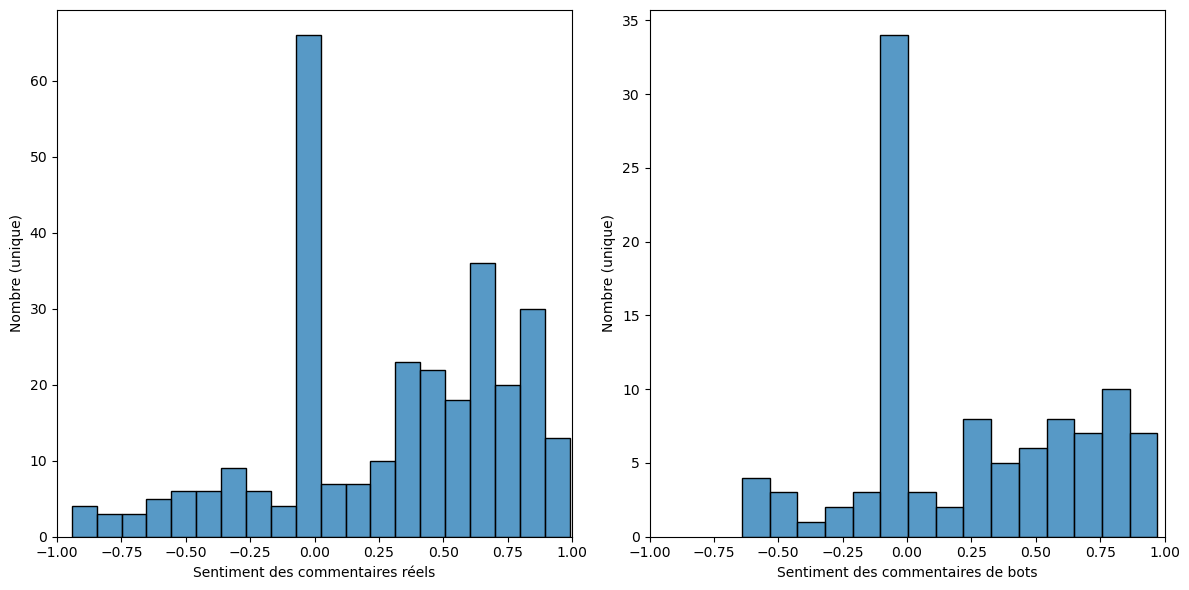

In [41]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    sns.histplot(df_gen_res['DEV__Sentiment__compound'], ax=axs[0], bins=20)
    axs[0].set_xlabel('Sentiment des commentaires réels')
    axs[0].set_ylabel('Nombre (unique)')  # Solidarité avec le deuxième graphique.
    axs[0].set_xlim(-1, 1)
    
    sns.histplot(df_bot_res['DEV__Sentiment__compound'], ax=axs[1], bins=15)
    axs[1].set_xlabel('Sentiment des commentaires de bots')
    axs[1].set_ylabel('Nombre (unique)')  # Nous ne nous soucions pas des commentaires dupliqués ici.
    axs[1].set_xlim(-1, 1)
    
plt.tight_layout()
plt.show()

### Préparation des données des commentaires de bots pour l'analyse

In [43]:
df_bot_unique_flatindex = df_bot_unique.copy()
df_bot_unique_flatindex.columns = df_bot_unique_flatindex.columns.map('_'.join)
df_bot_unique_flatindex['count'] = df_bot_unique_flatindex['Likes_count']
df_bot_unique_flatindex = df_bot_unique_flatindex.drop(['Likes_count', 'Reply Count_count'], axis=1)
df_bot_unique_flatindex = df_bot_unique_flatindex.sort_values(by=['count', 'Likes_mean'], ascending=False).reset_index()

### Fusion et affichage des données des commentaires de bots

In [45]:
# Avertissement, sortie volumineuse ci-dessous.
merged_bot_df = df_bot_unique_flatindex.merge(df_bot_res, on='Comment')

# Affichage du DataFrame complet
with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
    display(merged_bot_df)

,Comment,Likes_mean,Reply Count_mean,count,Likes,Reply Count,DEV__PreprocessedComment,DEV__Sentiment__neg,DEV__Sentiment__neu,DEV__Sentiment__pos,DEV__Sentiment__compound
0,❤,2.0,0.000000,1994,2.0,0.000000,❤,0.000,0.000,0.000,0.0000
1,In the time it took me to watch this in 1.5x speed the views went from 500k to over 1.7 million. People are starving for real dialogue and real news. They want to hear things from the horses mouth instead of being fed what others think they should hear. Whether what he said was true or not we want to hear both sides of the story. Great job Tucker!,542.0,35.000000,997,542.0,35.000000,time took watch 1.5x speed view went 500k 1.7 million . people starving real dialogue real news . want hear thing horse mouth instead fed others think hear . whether said true want hear side story . great job tucker !,0.064,0.711,0.225,0.7177
2,Cant wait to see how the press spins this tomorrow.,471.0,16.000000,997,471.0,16.000000,cant wait see press spin tomorrow .,0.000,1.000,0.000,0.0000
3,"Im Russian but I prefer to watch this in English in order to understand has Putins speech been translated correctly. So far Im satisfied with translation good work, still watching. Guys forward & repost this video.",461.0,28.000000,997,461.0,28.000000,"im russian prefer watch english order understand putin speech translated correctly . far im satisfied translation good work , still watching . guy forward & repost video .",0.000,0.787,0.213,0.6908
4,Thank you Tucker for allowing him to speak without you interrupting.,402.0,11.000000,997,402.0,11.000000,thank tucker allowing speak without interrupting .,0.000,0.477,0.523,0.5248
5,Watched from Canada. This interview needed to happen.,390.0,1.000000,997,390.0,1.000000,watched canada . interview needed happen .,0.000,1.000,0.000,0.0000
6,Very interesting and as a free Citizen of the US I deserved the ability to hear it.,389.0,14.000000,997,389.0,14.000000,interesting free citizen u deserved ability hear .,0.000,0.265,0.735,0.8074
7,"I can say that translator was 99% close to his speech!! We made double check in rus and eng! Be sure translator made all meaning correct! Спасибо, Такер!",237.0,7.000000,997,237.0,7.000000,"say translator 99 % close speech ! ! made double check ru eng ! sure translator made meaning correct ! спасибо , такер !",0.000,0.822,0.178,0.5374
8,Watched from Florida. Thank you Tucker!God Bless Earth ❤,230.0,3.000000,997,230.0,3.000000,watched florida . thank tucker ! god bless earth ❤,0.000,0.342,0.658,0.7712
9,34.8 million views on X after 3 hours.\nOnly about 321k on YouTube.🤔🤔🤔,219.0,26.000000,997,219.0,26.000000,34.8 million view x 3 hour . 321k youtube.🤔🤔🤔,0.000,1.000,0.000,0.0000


### Analyse des commentaires de bots uniques

In [47]:
ut_df = df.groupby('Comment').nunique()
ut_df = ut_df[ut_df['Anonymized Author'] > 1]  # Les auteurs sont uniques, donc c'est essentiellement un identifiant.

display(ut_df[ut_df['Published At'] > 1])  # Commentaires de bots qui n'ont PAS été publiés tous en même temps.
display(ut_df[ut_df['Likes'] > 1])  # Commentaires de bots qui n'ont pas exactement le même nombre de likes.
display(ut_df[ut_df['Reply Count'] > 1])  # Commentaires de bots qui n'ont pas exactement le même nombre de réponses.

,Anonymized Author,Published At,Likes,Reply Count,DEV__IsBotComment
Comment,,,,,
"The look on Tucker's face at the end of interview, sums it all.",2,2,2,2,1
❤,1994,2,1,1,1


,Anonymized Author,Published At,Likes,Reply Count,DEV__IsBotComment
Comment,,,,,
"The look on Tucker's face at the end of interview, sums it all.",2,2,2,2,1


,Anonymized Author,Published At,Likes,Reply Count,DEV__IsBotComment
Comment,,,,,
First I am an Air Force Veteran and Republican. I have voted republican since 1988. I voted for Trump twice. All I can say is Wow. I understand some of Putin's point of view but this is total madness. I actually expected hard questioning. Putin is obviously delusional and you just fed his ego.,997,1,1,2,1
"The look on Tucker's face at the end of interview, sums it all.",2,2,2,2,1


### Analyser des motifs temporels

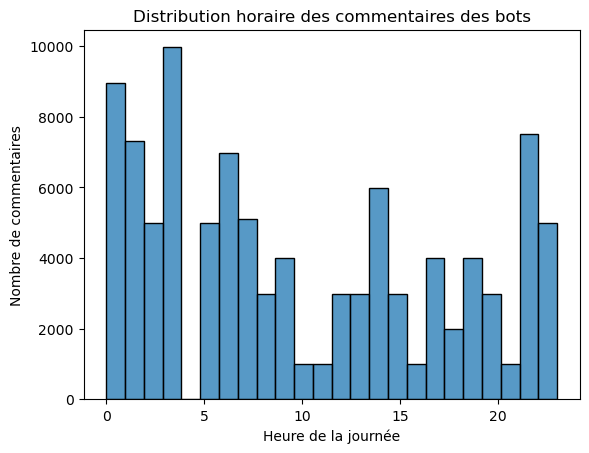

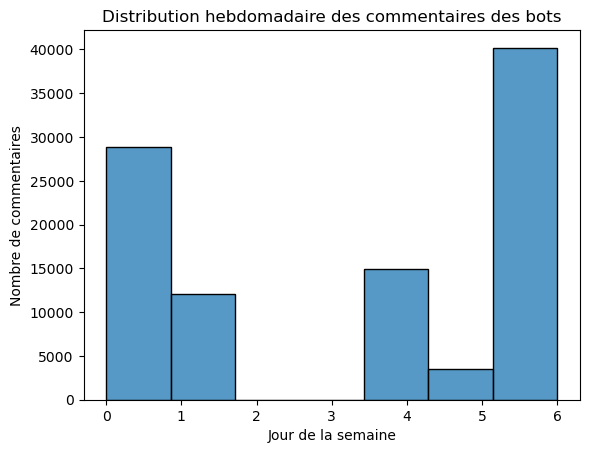

In [49]:
df['Published At'] = pd.to_datetime(df['Published At'])
df['hour'] = df['Published At'].dt.hour
df['day_of_week'] = df['Published At'].dt.dayofweek

sns.histplot(df[df['DEV__IsBotComment']]['hour'], bins=24)
plt.title('Distribution horaire des commentaires des bots')
plt.xlabel('Heure de la journée')
plt.ylabel('Nombre de commentaires')
plt.show()

sns.histplot(df[df['DEV__IsBotComment']]['day_of_week'], bins=7)
plt.title('Distribution hebdomadaire des commentaires des bots')
plt.xlabel('Jour de la semaine')
plt.ylabel('Nombre de commentaires')
plt.show()

### Analyse des similitudes des textes

/Users/user/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


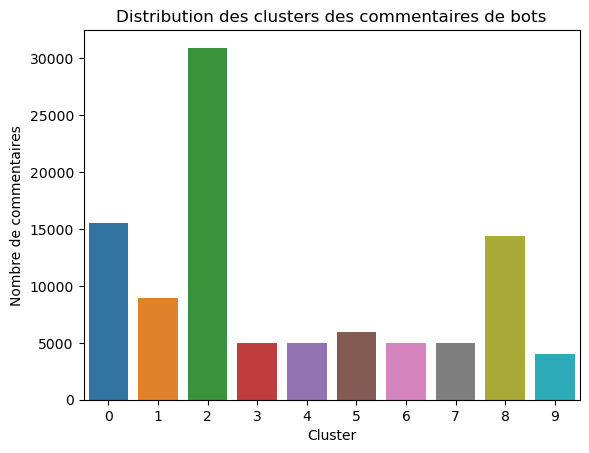

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans

vectorizer = TfidfVectorizer(max_features=1000, stop_words='english')
X = vectorizer.fit_transform(df['Comment'])

kmeans = KMeans(n_clusters=10, random_state=0).fit(X)
df['cluster'] = kmeans.labels_

sns.countplot(x='cluster', data=df[df['DEV__IsBotComment']])
plt.title('Distribution des clusters des commentaires de bots')
plt.xlabel('Cluster')
plt.ylabel('Nombre de commentaires')
plt.show()

### Exploration des biais

In [53]:
from sklearn.decomposition import LatentDirichletAllocation

lda = LatentDirichletAllocation(n_components=10, random_state=0)
lda.fit(X)

# Afficher les principaux termes par sujet
terms = vectorizer.get_feature_names_out()
for i, topic in enumerate(lda.components_):
    print(f"Top 10 termes pour le sujet {i}:")
    print(" ".join([terms[i] for i in topic.argsort()[-10:]]))
    print()

Top 10 termes pour le sujet 0:
화이팅 칼슨 터커 great interview jong kim putin professor cia

Top 10 termes pour le sujet 1:
ты мужчина настоящий deberías visitar cuba jane fonda american wait

Top 10 termes pour le sujet 2:
question slavic interview money instead pride 54 10 interesting peace

Top 10 termes pour le sujet 3:
florida earth canada happen translator obiden doesnt watched states needed

Top 10 termes pour le sujet 4:
peru opener god bless clearly story sure eye love finally

Top 10 termes pour le sujet 5:
minds dollar depends 42 18 war 862 9th century come

Top 10 termes pour le sujet 6:
man watched live interview speak love far tucker watching thank

Top 10 termes pour le sujet 7:
kings plays definitely russian hours interview best end journalist putin

Top 10 termes pour le sujet 8:
interview spent hear explain real time shadowbanned happy youtube history

Top 10 termes pour le sujet 9:
called tucker people president putin interview million know don make



### Validation croisée

In [55]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

# Exemple : Utilisation d'une régression linéaire pour prédire les likes sur les commentaires de bots
X = df_bot_res[['Reply Count', 'DEV__Sentiment__neg', 'DEV__Sentiment__neu', 'DEV__Sentiment__pos', 'DEV__Sentiment__compound']]
y = df_bot_res['Likes']

model = LinearRegression()

# Validation croisée avec 5 folds
scores = cross_val_score(model, X, y, cv=5)
print(f"Scores de validation croisée : {scores}")
print(f"Moyenne des scores : {scores.mean()}")

Scores de validation croisée : [ 5.74365800e-01  8.49750768e-01  5.85257302e-01  2.95046317e-01
 -7.24394943e+02]
Moyenne des scores : -144.4181046604449


### Tests A/B

In [57]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# Diviser les données en deux groupes A et B
group_A = df_bot_res.sample(frac=0.5, random_state=0)
group_B = df_bot_res.drop(group_A.index)

# Exemple : Comparaison entre deux méthodes (Random Forest vs Linear Regression)
X_A = group_A[['Reply Count', 'DEV__Sentiment__neg', 'DEV__Sentiment__neu', 'DEV__Sentiment__pos', 'DEV__Sentiment__compound']]
y_A = group_A['Likes']

X_B = group_B[['Reply Count', 'DEV__Sentiment__neg', 'DEV__Sentiment__neu', 'DEV__Sentiment__pos', 'DEV__Sentiment__compound']]
y_B = group_B['Likes']

model_A = RandomForestRegressor(random_state=0)
model_B = LinearRegression()

model_A.fit(X_A, y_A)
model_B.fit(X_B, y_B)

# Évaluation des performances sur les groupes A et B
mse_A = mean_squared_error(y_A, model_A.predict(X_A))
mse_B = mean_squared_error(y_B, model_B.predict(X_B))

print(f"Erreur quadratique moyenne (MSE) pour le modèle A : {mse_A}")
print(f"Erreur quadratique moyenne (MSE) pour le modèle B : {mse_B}")

# Comparaison des résultats
if mse_A < mse_B:
    print("Le modèle A est meilleur que le modèle B.")
else:
    print("Le modèle B est meilleur que le modèle A.")

Erreur quadratique moyenne (MSE) pour le modèle A : 2603.0758414282222
Erreur quadratique moyenne (MSE) pour le modèle B : 3320.445459377143
Le modèle A est meilleur que le modèle B.
